In this notebook, we will present how to merge datasets in scVI

In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
use_cuda = True

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset.pbmc import Dataset10X, PbmcDataset

from scvi.inference.posterior import *
from scvi.metrics.clustering import select_indices_evenly, clustering_scores, entropy_batch_mixing
from scipy import sparse
from scvi.models.vae import VAE
from scvi.inference import UnsupervisedTrainer

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pbmc = PbmcDataset()

File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 21425 genes
Downsampling from 8381 to 8381 cells
File data/10X/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 19773 genes
Downsampling from 4340 to 4340 cells
Keeping 19039 genes
Downsampling from 12721 to 11990 cells
Downsampling from 19039 to 19036 genes
Downsampling from 11990 to 11990 cells
Downsampling from 19036 to 3346 genes
Downsampling from 11990 to 11990 cells


In [4]:
pbmc.cell_types

array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
       'Dendritic Cells', 'FCGR3A+ Monocytes', 'Megakaryocytes',
       'NK cells', 'Other'], dtype=object)

In [5]:
cell_types = np.array(["cd4_t_helper", "regulatory_t", "naive_t", "memory_t", "cytotoxic_t", "naive_cytotoxic",
                       "b_cells", "cd34", "cd56_nk", "cd14_monocytes"])
cell_type_name = np.array(["CD4 T cells", "CD4 T cells Regulatory", "CD4 T cells Naive", "CD4 Memory T cells", "CD8 T cells", "CD8 T cells Naive",
                       "B cells", "CD34 cells", "NK cells", "CD14+ Monocytes"])

datasets = []
for i,cell_type in enumerate(cell_types):
    dataset = Dataset10X(cell_type, save_path='data/')
    dataset.cell_types = np.array([cell_type_name[i]])
    dataset.subsample_genes(dataset.nb_genes)
    dataset.gene_names = dataset.gene_symbols
    datasets += [dataset]

pure = GeneExpressionDataset.concat_datasets(*datasets, shared_batches=True)


File data/10X/cd4_t_helper/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16049 genes
Downsampling from 11213 to 11213 cells
File data/10X/regulatory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15950 genes
Downsampling from 10263 to 10263 cells
File data/10X/naive_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15565 genes
Downsampling from 10479 to 10479 cells
File data/10X/memory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16169 genes
Downsampling from 10224 to 10224 cells
File data/10X/cytotoxic_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16130 genes

In [6]:
gene_dataset = GeneExpressionDataset.concat_datasets(pbmc, pure)

Keeping 2934 genes


In [7]:
gene_dataset.X.shape

(106645, 2934)

In [8]:
gene_dataset.cell_types

array(['CD4 T cells Naive', 'CD14+ Monocytes', 'Megakaryocytes',
       'NK cells', 'CD8 T cells Naive', 'CD4 Memory T cells', 'B cells',
       'CD4 T cells', 'CD4 T cells Regulatory', 'CD8 T cells',
       'Dendritic Cells', 'Other', 'CD34 cells', 'FCGR3A+ Monocytes'],
      dtype='<U22')

In [9]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=100)

training: 100%|██████████| 100/100 [22:09<00:00, 13.29s/it]


In [13]:
import torch
torch.save(trainer.model,'../models/pbmc_pure.vae.pkl')

In [15]:
latent, batch_indices, labels = trainer.train_set.get_latent(sample=True)
# latent, idx_t_sne = trainer.train_set.apply_t_sne(latent, 10000)

In [16]:
np.unique(batch_indices[:, 0])

array([0, 1, 2])

In [19]:
from scvi.metrics.clustering import select_indices_evenly
from sklearn.manifold import TSNE
import seaborn as sns


In [25]:
sample = select_indices_evenly(2000, labels)
colors = sns.color_palette('tab20')
latent_s = latent[sample, :]
label_s = labels[sample]
batch_s = batch_indices[sample]

In [30]:
if latent_s.shape[1] != 2:
    latent_s = TSNE().fit_transform(latent_s)

In [31]:
latent_s.shape

(21241, 2)

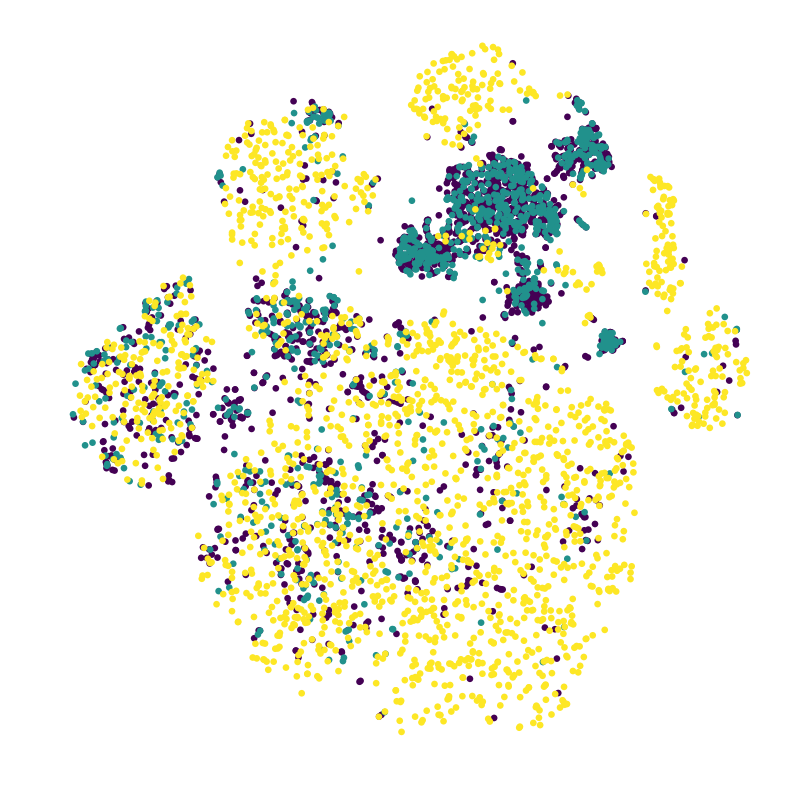

In [38]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
batch_s = batch_s.ravel()
sample = select_indices_evenly(2000, batch_s)

plt.scatter(latent_s[sample, 0], latent_s[sample, 1], c=batch_s[sample], edgecolors='none')
plt.axis("off")
plt.tight_layout()
plt.show()

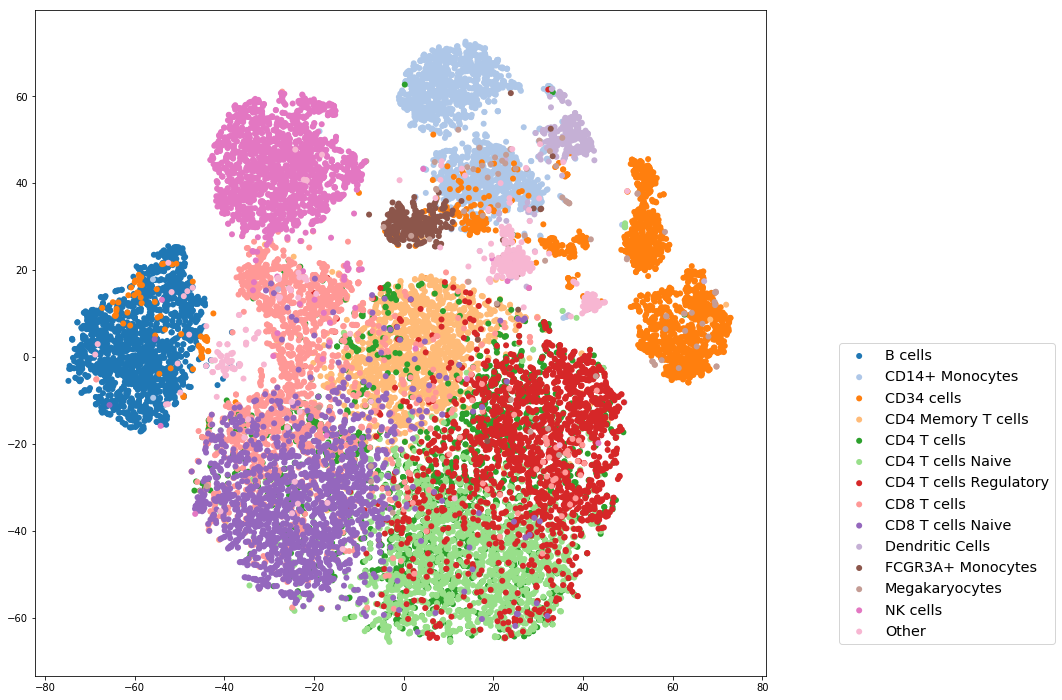

In [43]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(15, 10))
for i,k in enumerate(key_order):
    ax.scatter(latent_s[label_s == k, 0], latent_s[label_s == k, 1], c=colors[i%20], label=keys[k],
               edgecolors='none')
    ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
fig.tight_layout()
